# Compound Steps in Sampling
This notebook explains how the compound steps work in `pymc3.sample` function when sampling multiple random variables. We are going to answer the following questions associated with compound steps:

- How do compound steps work?
- What happens when PyMC3 assigns step methods by default?
- How to specify the step methods? What is the order to apply the step methods at each iteration? Is there a way to specify the order of the step methods? 
- What are the issues with mixing discrete and continuous samplers, especially with HMC/NUTS?
- What happens to variables that occur in multiple samplers? 

To conduct Markov chain Monte Carlo (MCMC) sampling to generate posterior samples in PyMC3, we specify a step method object that corresponds to a particular MCMC algorithm, such as Metropolis, Slice sampling, or the No-U-Turn Sampler (NUTS). PyMC3’s step_methods submodule contains the following samplers: NUTS, Metropolis, Slice, HamiltonianMC, and BinaryMetropolis. These step methods can be assigned manually, or assigned automatically by PyMC3. Auto-assignment is based on the attributes of each variable in the model. In general:

- Binary variables will be assigned to BinaryMetropolis
- Discrete variables will be assigned to Metropolis
- Continuous variables will be assigned to NUTS

Auto-assignment can be overriden for any subset of variables by specifying them manually prior to sampling.


In [1]:
import arviz as az
import numpy as np
import pymc3 as pm
import theano

az.style.use("arviz-darkgrid")

## Compound steps

When sampling a model with multiple free random variables, compound steps are needed in the `pm.sample` function. When compound steps are involved, the function takes a list of `step` to generate a list of `methods` for different random variables. For example in the following code:
```python
with pm.Model() as m:
    rv1 = ... # random variable 1 (continuous)
    rv2 = ... # random variable 2 (continuous)
    rv3 = ... # random variable 3 (categorical)
    ...
    step1 = pm.Metropolis([rv1, rv2])
    step2 = pm.CategoricalGibbsMetropolis([rv3])
    trace = pm.sample(..., step=[step1, step2]...)
```
The compound step now contains a list of `methods`. At each sampling step, it iterates over these methods, taking a `point` as input. In each step a new `point` is proposed as an output, if rejected by the Metropolis-Hastings criteria the original input `point` sticks around as the output. 

## Compound steps by default
When we call `pm.sample()`, `PyMC3` assigns the best step method to each of the free random variables. Take the following example:

In [2]:
n_ = theano.shared(np.asarray([10, 15]))
with pm.Model() as m:
    p = pm.Beta("p", 1.0, 1.0)
    ni = pm.Bernoulli("ni", 0.5)
    k = pm.Binomial("k", p=p, n=n_[ni], observed=4)

In [3]:
with m:
    trace = pm.sample(10000, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p]
>BinaryGibbsMetropolis: [ni]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 35 seconds.


There are two free parameters in the model we would like to sample from, a continuous variable `p_logodds__` and a binary variable `ni`.

In [4]:
m.free_RVs

[p_logodds__ ~ TransformedDistribution, ni ~ Bernoulli]

When we call `pm.sample()`, `PyMC3` assigns the best step method to each of them. For example, `NUTS` was assigned to `p_logodds__` and `BinaryGibbsMetropolis` was assigned to `ni`.

## Specify compound steps
But we can also specify the steps manually:

In [5]:
coords = {"step": ["BinaryMetropolis", "Metropolis"]}
dims = {"accept": ["step"]}

with pm.Model(coords=coords) as model:
    mu1 = pm.Bernoulli("mu1", p=0.8, dims="step")
    mu2 = pm.Normal("mu2", mu=0, sigma=1, dims="step")

In [6]:
with model:
    step1 = pm.BinaryMetropolis([mu1])
    step2 = pm.Metropolis([mu2])

    trace = pm.sample(
        10000,
        init=None,
        step=[step1, step2],
        cores=2,
        tune=1000,
        return_inferencedata=True,
        idata_kwargs={"dims": dims, "coords": coords},
    )

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryMetropolis: [mu1]
>Metropolis: [mu2]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [9]:
point = model.test_point
point

{'mu1': array([1, 1]), 'mu2': array([0., 0.])}

Then pass the `point` to the first step method `pm.Metropolis` for random variable `p`.

In [10]:
point, state = step1.step(point=point)
point, state

({'mu1': array([0, 1]), 'mu2': array([0., 0.])},
 [{'tune': True, 'accept': 0.24999999999999994, 'p_jump': 0.5}])

As you can see, the value of  `ni` does not change, but `p_logodds__` is updated.

And similarly, you can pass the updated `point` to `step2` and get a sample for `ni`:

In [11]:
point = step2.step(point=point)
point

({'mu1': array([0, 1]), 'mu2': array([0., 0.])},
 [{'tune': True,
   'scaling': array([1.]),
   'accept': 0.5800003053440143,
   'accepted': False}])

Compound step works exactly like this by iterating all the steps within the list. In effect, it is a metropolis hastings within gibbs sampling. 

Moreover, `pm.CompoundStep` is called internally by `pm.sample()`. We can make them explicit as below:

In [12]:
with m:
    comp_step1 = pm.CompoundStep([step1, step2])
comp_step1.methods

## Order of step methods

When in the default setting, the parameter update order follows the same order of the random variables, and it is assigned automatically. But if you specify the steps, you can change the order of the methods in the list:

In [13]:
with m:
    comp_step2 = pm.CompoundStep([step2, step1])
comp_step2.methods

In the sampling process, it always follows the same step order in each sample in the Gibbs-like fashion. More precisely, at each update, it iterates over the list of `methods` where the accept/reject is based on comparing the acceptance rate with $p \sim \text{Uniform}(0, 1)$ (by checking whether $\log p < \log p_{\text {updated}} - \log p_{\text {current}}$).

## Issues with mixing discrete and continuous sampling

A recurrent issue/concern is the validity of mixing discrete and continuous sampling, especially mixing other samplers with NUTS. While in the book [Bayesian Data Analysis 3rd edition](http://www.stat.columbia.edu/~gelman/book/) Chapter 12.4, there is a small paragraph on "Combining Hamiltonian Monte Carlo with Gibbs sampling", which suggests that this could be a valid way to do, the Stan developers are always skeptical about how practical it is. (Here are more discussions about this issue [1](http://discourse.mc-stan.org/t/mcmc-sampling-does-not-work-when-execute/1918/47), [2](http://discourse.mc-stan.org/t/constraining-latent-factor-model-baysian-probabalisic-matrix-factorization-to-remove-multimodality/2152/21)). 

The concern with mixing discrete and continuous sampling is that the change in discrete parameters will affect the continuous distribution's geometry so that the adaptation (i.e., the tuned mass matrix and step size) may be inappropriate for the Hamiltonian Monte Carlo sampling. HMC/NUTS is hypersensitive to its tuning parameters (mass matrix and step size). Another issue is that we also don't know how many iterations we have to run to get a decent sample when the discrete parameters change. Though it hasn't been fully evaluated, it seems that if the discrete parameter is in low dimensions (e.g., 2-class mixture models, outlier detection with explicit discrete labeling), the mixing of discrete sampling with HMC/NUTS works OK. However, it is much less efficient than marginalizing out the discrete parameters. And sometimes it can be observed that the Markov chains get stuck quite often. In order to evaluate this more properly, one can use a simulation-based method to look at the posterior coverage and establish the computational correctness, as explained in [Cook, Gelman, and Rubin 2006](https://amstat.tandfonline.com/doi/abs/10.1198/106186006x136976).

# Sampler Stats

These are the Sample Stats for Compound Step based sampling

In [14]:
list(trace.sample_stats.data_vars)

['scaling', 'p_jump', 'accept', 'accepted']

Note: In compound step method, sometimes a variable maybe present in both samplers, in this case `accept`.

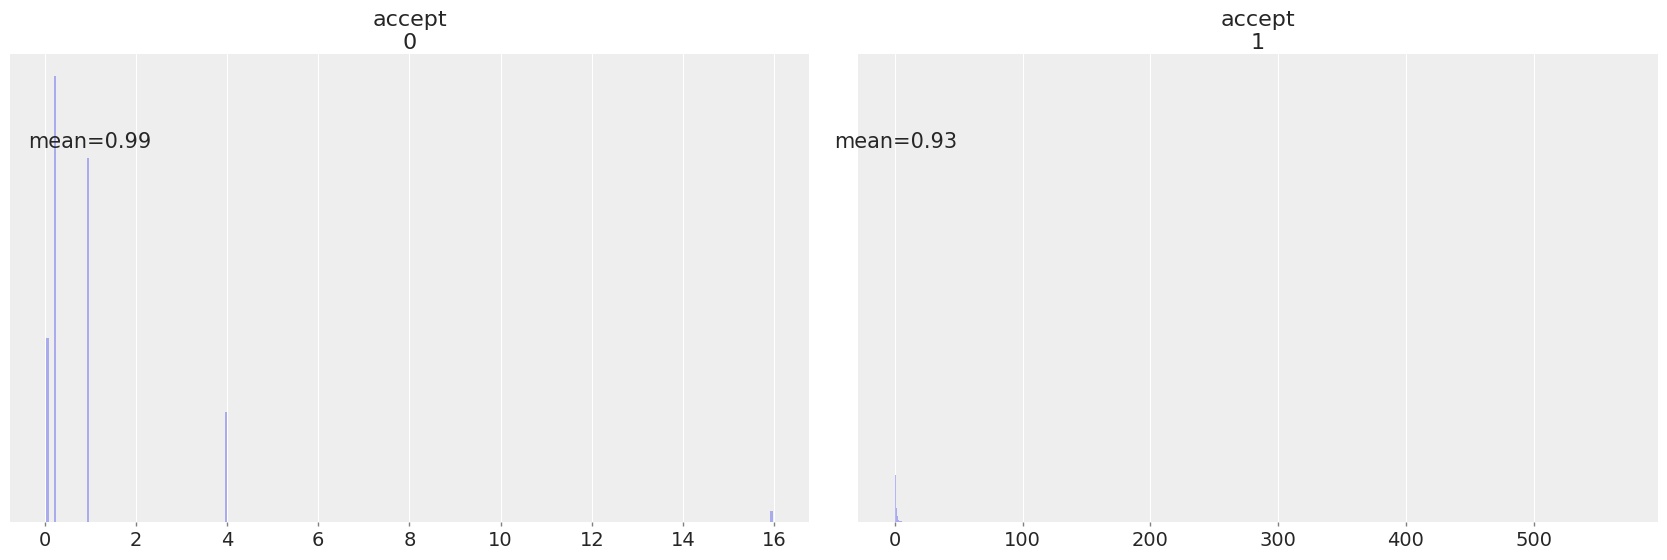

In [15]:
# Plotting this can be useful to identify outliers and understanding both samplers.
az.plot_posterior(
    trace,
    group="sample_stats",
    var_names="accept",
    hdi_prob="hide",
    kind="hist",
);

Updated by: Meenal Jhajharia

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Apr 05 2021

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

numpy : 1.20.1
theano: 1.1.2
arviz : 0.11.2
pymc3 : 3.11.2

Watermark: 2.2.0

